In [1]:
import torch
import torch.nn as nn
import torch.utils.data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

### Generating and visualising training data

In [2]:
def get_samples(num_of_points, random=True):
    train_data = torch.zeros((num_of_points, 1))
    if random:
        freq = np.random.uniform(1.2, 1.5)
    else:
        freq = 1
    signal = np.array([np.sin(i*freq) for i in range(num_of_points)])
    train_data[:, 0] = torch.from_numpy(signal)
    
    return train_data

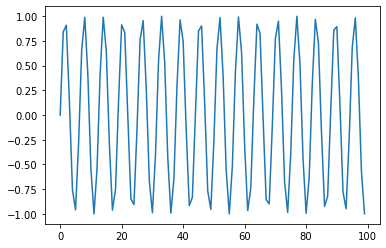

In [3]:
num_of_points = 100

train_data = get_samples(num_of_points, False)

plt.plot(train_data)

In [4]:
train_labels = torch.zeros(num_of_points)
train_dataset = [(train_data[i], train_labels[i]) for i in range(num_of_points)]

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=num_of_points)

In [6]:
print(train_loader)

### Defining models

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, output_size, layers, p=0.4):
        super().__init__()
        
       
        #layers
        
        layerlist = []
        n_in = input_size
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1], output_size))
        layerlist.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x):
        return self.layers(x)  

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, layers, p=0.4):
        super().__init__()
          
        layerlist = []
        n_in = input_size
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1], output_size))
        
        
        self.layers = nn.Sequential(*layerlist)
        
        
    def forward(self, x):
        
        return torch.tanh(self.layers(x))

In [9]:
input_size = 1

d_output_size = 1
g_output_size = 1

d_layers = [256, 128, 64]
g_layers = [32, 64]

In [10]:
D = Discriminator(input_size, d_output_size, d_layers)
G = Generator(input_size, g_output_size, g_layers)

In [11]:
print(D)

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [12]:
print(G)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training

In [13]:
def loss_function(D_out, label):
    if label == 1:
        labels = torch.ones(num_of_points, 1)
    else:
        labels = torch.zeros(num_of_points, 1)
        
    criterion = nn.BCELoss()
    
    loss = criterion(D_out, labels)
    
    return loss


In [14]:
import torch.optim as optim

lr = 0.002

#Createing optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [15]:
num_epochs = 2000


losses = []


for epoch in range(num_epochs):
    for batch_i , (real_samples, _) in enumerate(train_loader):
    
        # Training the discriminator 
        # 1) with real samples
        
        d_optimizer.zero_grad()

        D_real = D(real_samples)

        d_real_loss = loss_function(D_real, 1)
        
        # 2) with fake samples

        latent_space_samples = torch.randn((num_of_points, 1))
        
        fake_samples = G(latent_space_samples)
        
        D_fake = D(fake_samples)
        
        d_fake_loss = loss_function(D_fake, 0)
        
        #adding fake loss and real loss 
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        #Training the generator
        
        g_optimizer.zero_grad()
        
        latent_space_samples = torch.randn((num_of_points, 1))
        
        fake_samples = G(latent_space_samples)
        
        #computing discriminator losses on fake samples

        D_fake = D(fake_samples)

        g_loss = loss_function(D_fake, 1)

        g_loss.backward()

        g_optimizer.step()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
            
    losses.append((d_loss.item(), g_loss.item()))
    
        

Epoch 0, d_loss: 1.3859105110168457, g_loss: 0.6749248504638672
Epoch 50, d_loss: 1.331656575202942, g_loss: 0.7390414476394653
Epoch 100, d_loss: 1.390320062637329, g_loss: 0.6909618973731995
Epoch 150, d_loss: 1.385643482208252, g_loss: 0.685757577419281
Epoch 200, d_loss: 1.3641693592071533, g_loss: 0.6998282074928284
Epoch 250, d_loss: 1.3776869773864746, g_loss: 0.6927033066749573
Epoch 300, d_loss: 1.3821289539337158, g_loss: 0.6842607259750366
Epoch 350, d_loss: 1.3814599514007568, g_loss: 0.6880776882171631
Epoch 400, d_loss: 1.3849483728408813, g_loss: 0.7029696106910706
Epoch 450, d_loss: 1.388959527015686, g_loss: 0.7047528028488159
Epoch 500, d_loss: 1.3832838535308838, g_loss: 0.6979082226753235
Epoch 550, d_loss: 1.3819890022277832, g_loss: 0.6702671051025391
Epoch 600, d_loss: 1.386256456375122, g_loss: 0.6981901526451111
Epoch 650, d_loss: 1.39504075050354, g_loss: 0.6969670653343201
Epoch 700, d_loss: 1.3835382461547852, g_loss: 0.6994920372962952
Epoch 750, d_loss: 1.

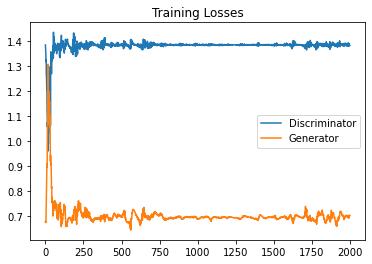

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()



In [17]:
sample_test_noise = torch.randn(num_of_points, 1)
generated = G(sample_test_noise)

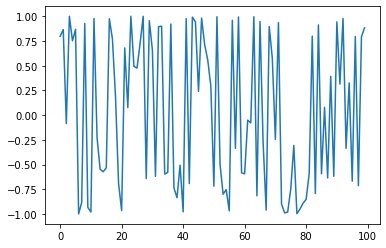

In [18]:
signal = [x for x in generated]
plt.plot(signal)

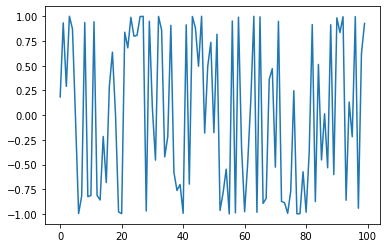

In [19]:
generated2 = G(sample_test_noise)
signal = [x for x in generated2]
plt.plot(signal)